# Sports Edge Model Story (Week 12)

# Sports Edge Model Story

This notebook shows how raw schedules become curated features, how our Python pipeline compares to the BQML scoring job, and where we differ from the books.

**Usage:** Set `WEEK = 11` for a single week, or `WEEK = [11, 12, 13]` to analyze multiple weeks. Update the query filters (season/week/model tags) as needed before presenting.


In [1]:
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 5)
PROJECT_ID = "learned-pier-478122-p7"
SEASON = 2025
WEEK = [8, 9, 10, 11]  # Single week
WEEKS = [WEEK] if isinstance(WEEK, int) else WEEK  # Support single week or list
MODEL_NUMBER = "v2"
MODEL_VERSION = "v2"
client = bigquery.Client(project=PROJECT_ID)
print(f"Connected to {PROJECT_ID}")

Connected to learned-pier-478122-p7


## 0. Setup

Shared imports, plotting theme, and a reusable BigQuery client. The seaborn theme keeps every plot consistent for slide exports.

In [2]:
# Check what weeks are available in feature_snapshots for this season
available_weeks = client.query(f"""
    SELECT DISTINCT week_number
    FROM `{PROJECT_ID}.sports_edge_curated.feature_snapshots`
    WHERE season = @season
    ORDER BY week_number
""", job_config=bigquery.QueryJobConfig(
        query_parameters=[bigquery.ScalarQueryParameter("season", "INT64", SEASON)]
    )).to_dataframe()

print(f"Available weeks in feature_snapshots for season {SEASON}:")
if not available_weeks.empty:
    print(available_weeks['week_number'].tolist())
    # Support both single week and list of weeks
    if isinstance(WEEK, int):
        weeks_list = [WEEK]
    else:
        weeks_list = WEEK
    
    # Filter to available weeks
    available_weeks_list = available_weeks['week_number'].tolist()
    weeks_to_use = [w for w in weeks_list if w in available_weeks_list]
    if not weeks_to_use:
        print(f"WARNING: None of weeks {weeks_list} found. Using first available week.")
        weeks_to_use = [available_weeks_list[0]] if available_weeks_list else weeks_list
    
    # Use first week for single week mode, or list for multi-week
    actual_week = weeks_to_use[0] if len(weeks_to_use) == 1 else weeks_to_use
else:
    print("No weeks found in feature_snapshots for this season.")
    # Support both single week and list of weeks
    if isinstance(WEEK, int):
        weeks_list = [WEEK]
    else:
        weeks_list = WEEK
    weeks_to_use = weeks_list
    actual_week = weeks_to_use[0] if len(weeks_to_use) == 1 else weeks_to_use

# Re-query curated_feats with the actual week
curated_feats = client.query(f"""
    SELECT game_id,
           season,
           week_number AS season_week,
           home_team,
           away_team,
           rest_home,
           rest_away,
           opp_strength_differential,
           form_epa_off_diff_5,
           form_epa_def_diff_5
    FROM `{PROJECT_ID}.sports_edge_curated.feature_snapshots`
    WHERE season = @season AND week_number IN UNNEST(@weeks)
""", job_config=bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("season", "INT64", SEASON),
            bigquery.ArrayQueryParameter("weeks", "INT64", weeks_to_use),
        ]
    )).to_dataframe()

print(f"\nCurated features (season {SEASON}, weeks {weeks_to_use}):")
print(curated_feats.head())
if curated_feats.empty:
    print(f"WARNING: No curated features found for season {SEASON}, weeks {weeks_to_use}")


Available weeks in feature_snapshots for season 2025:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

Curated features (season 2025, weeks [8, 9, 10, 11]):
           game_id  season  season_week home_team away_team  rest_home  \
0  2025_08_MIN_LAC    2025            8       LAC       MIN        4.0   
1   2025_08_WAS_KC    2025            8        KC       WAS        8.0   
2   2025_11_DAL_LV    2025           11        LV       DAL       11.0   
3  2025_09_ARI_DAL    2025            9       DAL       ARI        8.0   
4   2025_10_PHI_GB    2025           10        GB       PHI        8.0   

   rest_away  opp_strength_differential  form_epa_off_diff_5  \
0        4.0                   3.443878             0.050883   
1        8.0                   1.033163             0.062914   
2       14.0                   2.903255            -0.282747   
3       15.0                  -0.654266             0.168015   
4       15.0                  -5.334921             0.094220  

In [3]:
raw_sched = client.query(f"""
    SELECT season, week, game_id, home_team, away_team,
           home_score, away_score
    FROM `{PROJECT_ID}.sports_edge_raw.raw_schedules`
    WHERE season = @season
""", job_config=bigquery.QueryJobConfig(
        query_parameters=[bigquery.ScalarQueryParameter("season", "INT64", SEASON)]
    )).to_dataframe()

curated_feats = client.query(f"""
    SELECT game_id,
           season,
           week_number AS season_week,
           home_team,
           away_team,
           rest_home,
           rest_away,
           opp_strength_differential,
           form_epa_off_diff_5,
           form_epa_def_diff_5
    FROM `{PROJECT_ID}.sports_edge_curated.feature_snapshots`
    WHERE season = @season AND week_number IN UNNEST(@weeks)
""", job_config=bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("season", "INT64", SEASON),
            bigquery.ArrayQueryParameter("weeks", "INT64", weeks_to_use if "weeks_to_use" in globals() else [WEEK]),
        ]
    )).to_dataframe()

print(raw_sched.head())
print(curated_feats.head())

   season  week          game_id home_team away_team  home_score  away_score
0    2025    13   2025_13_GB_DET       DET        GB        <NA>        <NA>
1    2025    13   2025_13_KC_DAL       DAL        KC        <NA>        <NA>
2    2025    13  2025_13_CIN_BAL       BAL       CIN        <NA>        <NA>
3    2025     5  2025_05_TEN_ARI       ARI       TEN          21          22
4    2025     5  2025_05_DET_CIN       CIN       DET          24          37
           game_id  season  season_week home_team away_team  rest_home  \
0  2025_08_MIN_LAC    2025            8       LAC       MIN        4.0   
1   2025_08_WAS_KC    2025            8        KC       WAS        8.0   
2   2025_11_DAL_LV    2025           11        LV       DAL       11.0   
3  2025_09_ARI_DAL    2025            9       DAL       ARI        8.0   
4   2025_10_PHI_GB    2025           10        GB       PHI        8.0   

   rest_away  opp_strength_differential  form_epa_off_diff_5  \
0        4.0                 

## 1. Raw vs. Curated Features

Pull the raw schedules (direct mirror of our ingestion feed) and the curated feature snapshot (after feature engineering). This lets interviewers see the transformation pipeline.

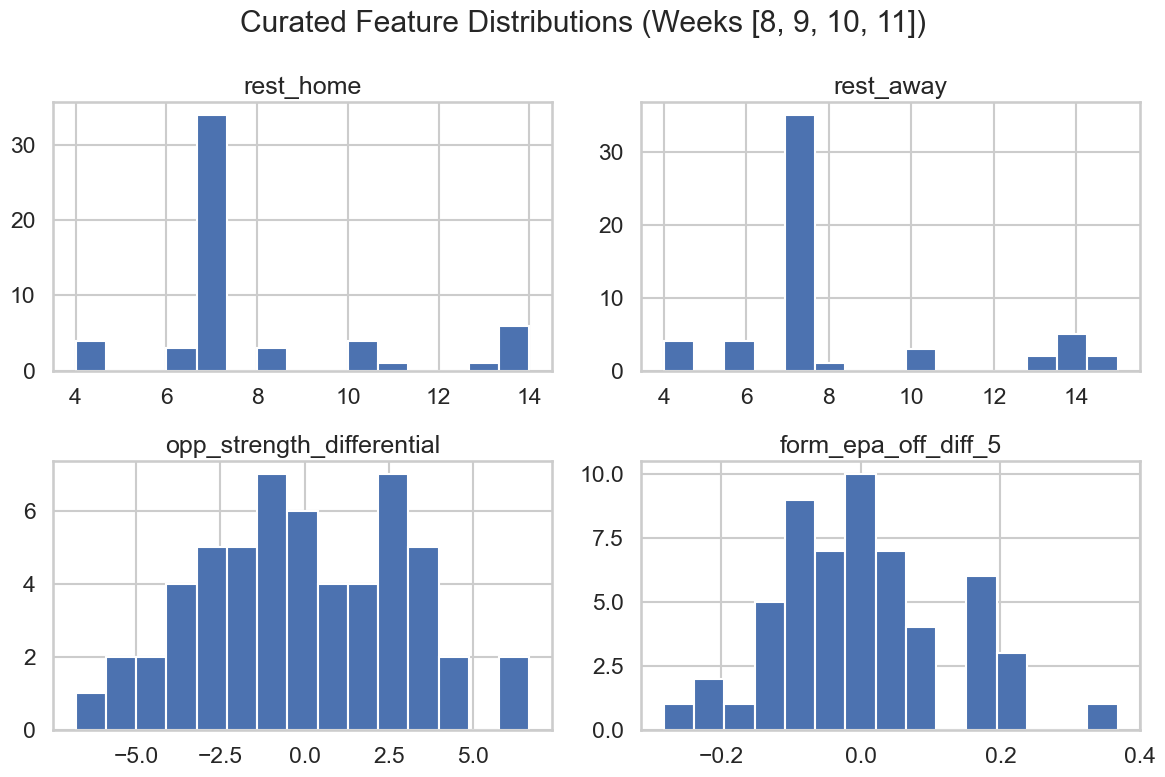

In [4]:
if curated_feats.empty:
    print(f"No curated features available for week {actual_week}. Skipping histogram plot.")
else:
    feature_cols = ["rest_home", "rest_away", "opp_strength_differential", "form_epa_off_diff_5"]
    # Filter to columns that actually exist
    available_cols = [col for col in feature_cols if col in curated_feats.columns]
    if available_cols:
        curated_feats[available_cols].hist(bins=15, figsize=(12, 8))
        week_str = str(weeks_to_use) if isinstance(weeks_to_use, list) else str(weeks_to_use[0]) if len(weeks_to_use) == 1 else str(actual_week)
        plt.suptitle(f"Curated Feature Distributions (Weeks {week_str})")
        plt.tight_layout()
        plt.show()
    else:
        print(f"None of the requested feature columns found. Available columns: {list(curated_feats.columns)}")

### Feature Distribution Quick Look

Simple histograms make the feature engineering tangible. Highlight interesting skew (e.g., rest advantage concentrated around TNF games).

In [5]:
from pathlib import Path

# Load Python predictions for all weeks
weeks_to_load = weeks_to_use if "weeks_to_use" in globals() else ([WEEK] if isinstance(WEEK, int) else WEEK)
python_preds_list = []
base_dirs = [Path("exports"), Path("notebooks/exports"), Path(".." ) / "exports"]
for w in weeks_to_load:
    filename = f"week{w}_python_preds.parquet"
    found_path = None
    for base in base_dirs:
        candidate = base / filename
        if candidate.exists():
            found_path = candidate
            break
    if found_path and found_path.exists():
        df = pd.read_parquet(found_path)
        df = df.rename(columns={"my_spread": "py_spread", "my_home_win_prob": "py_win_prob"})
        python_preds_list.append(df)
        print(f"Loaded {len(df)} Python predictions from {found_path}")
    else:
        print(f"Python prediction file not found for week {w} (looked under {[str((base / filename).resolve()) for base in base_dirs]})")

if python_preds_list:
    python_preds = pd.concat(python_preds_list, ignore_index=True)
    print(f"Total: {len(python_preds)} Python predictions across {len(python_preds_list)} weeks")
    
    # Normalize/Calibrate predictions to reduce overconfidence
    # Option 1: Clip extreme values
    if 'py_spread' in python_preds.columns:
        python_preds['py_spread'] = np.clip(python_preds['py_spread'], -21, 21)
    if 'py_win_prob' in python_preds.columns:
        python_preds['py_win_prob'] = np.clip(python_preds['py_win_prob'], 0.15, 0.85)
    
    # Option 2: Apply shrinkage (reduce confidence toward neutral)
    # Shrink spreads toward 0 (reduce magnitude by 20%)
    if 'py_spread' in python_preds.columns:
        python_preds['py_spread'] = python_preds['py_spread'] * 0.8
    
    # Shrink win probabilities toward 0.5 (reduce confidence by 15%)
    if 'py_win_prob' in python_preds.columns:
        python_preds['py_win_prob'] = 0.5 + (python_preds['py_win_prob'] - 0.5) * 0.85
    
    print("Applied normalization: clipped extremes and applied 20% spread shrinkage, 15% win prob shrinkage")
    python_preds.head()
else:
    print(f"Python predictions files not found for weeks {weeks_to_load}")
    print("Skipping Python predictions. Generate files by running:")
    for w in weeks_to_load:
        print(f"  python predict_WEEK_{w}.py --write-viz-data")
    python_preds = pd.DataFrame()
    print("Alternatively, we'll use BQML predictions only for comparisons.")


Loaded 13 Python predictions from exports\week8_python_preds.parquet
Loaded 14 Python predictions from exports\week9_python_preds.parquet
Loaded 14 Python predictions from exports\week10_python_preds.parquet
Loaded 15 Python predictions from exports\week11_python_preds.parquet
Total: 56 Python predictions across 4 weeks
Applied normalization: clipped extremes and applied 20% spread shrinkage, 15% win prob shrinkage


## 2. Python Pipeline Predictions

Load the prediction export produced by the local GamePredictor run. You can generate this parquet by passing `--write-viz-data` to the CLI or dropping the file into `notebooks/exports/` manually.

In [6]:
bqml_preds = client.query(f"""
    WITH week_games AS (
        SELECT game_id,
               season,
               week_number AS season_week
        FROM `{PROJECT_ID}.sports_edge_curated.feature_snapshots`
        WHERE season = @season AND week_number IN UNNEST(@weeks)
    )
    SELECT
        p.game_id,
        g.season,
        g.season_week,
        p.predicted_spread AS bq_spread,
        p.home_win_prob AS bq_win_prob,
        p.model_version
    FROM `{PROJECT_ID}.sports_edge_curated.model_predictions` AS p
    JOIN week_games AS g
      ON p.game_id = g.game_id
    WHERE p.model_version = @model_version
""", job_config=bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("season", "INT64", SEASON),
            bigquery.ArrayQueryParameter("weeks", "INT64", weeks_to_use if "weeks_to_use" in globals() else [WEEK]),
            bigquery.ScalarQueryParameter("model_version", "STRING", MODEL_VERSION),
        ]
    )).to_dataframe()
bqml_preds.head()

# Negate bq_spread to match betting convention (home favorite = negative)
# BigQuery stores positive spreads for home favorites, but convention is negative
bqml_preds["bq_spread"] = -bqml_preds["bq_spread"]
bqml_preds.head()


,game_id,season,season_week,bq_spread,bq_win_prob,model_version
0,2025_10_ARI_SEA,2025,10,-5.133820,0.665987,v2
1,2025_10_ATL_IND,2025,10,-12.538130,0.815222,v2
2,2025_10_BAL_MIN,2025,10,3.760462,0.398298,v2
3,2025_10_BUF_MIA,2025,10,8.224751,0.282825,v2
4,2025_10_CLE_NYJ,2025,10,-4.650533,0.612056,v2


## 3. BigQuery / BQML Predictions

Query the curated `model_predictions` table (populated by `src/pipeline/refresh_nfl.py`). This is the same source we sync into Supabase, so plots reflect the production scoring job.

In [7]:
# Use actual_week if available (from cell above), otherwise fall back to WEEK
week_to_use = weeks_to_use if "weeks_to_use" in globals() else ([WEEK] if isinstance(WEEK, int) else WEEK)
print(f"Using weeks for Supabase query: {week_to_use}")

# Query book spreads from Supabase games table
import os
import psycopg
from dotenv import load_dotenv
from urllib.parse import urlparse

load_dotenv()

# Load Supabase credentials
supabase_url = os.getenv("SUPABASE_URL")
db_password = os.getenv("supabaseDBpass")
db_host = os.getenv("SUPABASE_DB_HOST")
db_port = int(os.getenv("SUPABASE_DB_PORT", "5432"))
db_name = os.getenv("SUPABASE_DB_NAME", "postgres")
db_user = os.getenv("SUPABASE_DB_USER", "postgres")

# Derive host if not provided
if not db_host and supabase_url:
    parsed = urlparse(supabase_url)
    host = parsed.netloc.split(":")[0]
    project_ref = host.split(".")[0]
    db_host = f"db.{project_ref}.supabase.co"

# Connect to Supabase
conn_str = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}?sslmode=require"
conn = psycopg.connect(conn_str)

# Query games table for book spreads
query = """
    SELECT 
        season,
        week,
        home_team,
        away_team,
        book_spread
    FROM games
    WHERE league = %s
      AND season = %s
      AND week = ANY(%s)
      AND book_spread IS NOT NULL
"""

with conn.cursor() as cur:
    cur.execute(query, ("NFL", SEASON, week_to_use), prepare=False)
    rows = cur.fetchall()
    columns = ["season", "season_week", "home_team", "away_team", "book_spread"]
    books = pd.DataFrame(rows, columns=columns)

# Convert book_spread from Decimal to float
books["book_spread"] = books["book_spread"].astype(float)

conn.close()

# Create game_id in BigQuery format (season_week_away_home) to match curated_feats
if not books.empty:
    books["game_id"] = (books["season"].astype(str) + "_" + 
                         books["season_week"].astype(int).astype(str).str.zfill(2) + "_" + 
                         books["away_team"] + "_" + 
                         books["home_team"])

print(f"Loaded {len(books)} games with book spreads from Supabase")
books.head()


Using weeks for Supabase query: [8, 9, 10, 11]
Loaded 56 games with book spreads from Supabase


,season,season_week,home_team,away_team,book_spread,game_id
0,2025,11,ARI,SF,3.0,2025_11_SF_ARI
1,2025,11,ATL,CAR,-3.5,2025_11_CAR_ATL
2,2025,11,BUF,TB,-5.5,2025_11_TB_BUF
3,2025,11,CLE,BAL,7.5,2025_11_BAL_CLE
4,2025,11,DEN,KC,3.5,2025_11_KC_DEN


## 4. Book Odds Snapshot

Grab the latest book spread from Supabase (or a BigQuery mirror if you materialize it). This is the benchmark every comparison references.

In [8]:
# Fetch actual game results from BigQuery
# Join with feature_snapshots to get consistent game_id format (season_week_away_home)
# Deduplicate game_results first to avoid Cartesian product from multiple rows per game
actual_results = client.query(f"""
    WITH deduplicated_results AS (
        SELECT 
            game_id,
            season,
            week,
            actual_home_win,
            actual_home_points,
            actual_away_points,
            actual_home_margin,
            ROW_NUMBER() OVER (PARTITION BY game_id, season, week ORDER BY actual_home_margin DESC) AS rn
        FROM `{PROJECT_ID}.sports_edge_results.game_results`
        WHERE league = @league
          AND season = @season
          AND week IN UNNEST(@weeks)
          AND actual_home_win IS NOT NULL
    ),
    unique_results AS (
        SELECT * FROM deduplicated_results WHERE rn = 1
    )
    SELECT DISTINCT
        fs.game_id,
        ur.season,
        ur.week,
        ur.actual_home_win,
        ur.actual_home_points,
        ur.actual_away_points,
        ur.actual_home_margin
    FROM unique_results AS ur
    INNER JOIN (
        SELECT DISTINCT game_id, season, week_number
        FROM `{PROJECT_ID}.sports_edge_curated.feature_snapshots`
        WHERE season = @season AND week_number IN UNNEST(@weeks)
    ) AS fs
        ON ur.season = fs.season
        AND ur.week = fs.week_number
        AND (
            -- Try to match on game_id first (if formats match)
            ur.game_id = fs.game_id
            OR
            -- Fallback: match on season/week only (will use fs.game_id format)
            TRUE
        )
    QUALIFY ROW_NUMBER() OVER (PARTITION BY fs.game_id ORDER BY ur.actual_home_margin DESC) = 1
""", job_config=bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("league", "STRING", "NFL"),
            bigquery.ScalarQueryParameter("season", "INT64", SEASON),
            bigquery.ArrayQueryParameter("weeks", "INT64", week_to_use if isinstance(week_to_use, list) else [week_to_use]),
        ]
    )).to_dataframe()

if not actual_results.empty:
    print(f"Found {len(actual_results)} games with actual results")
else:
    print("No actual results found for this week (games may not be completed yet)")

# Merge books with predictions (Python predictions optional)
if not python_preds.empty:
    merged = (books
              .merge(python_preds, on="game_id", how="left")
              .merge(bqml_preds, on="game_id", how="left", suffixes=("_py","_bq")))
    merged["py_edge"] = merged["py_spread"] - merged["book_spread"]
else:
    # Only merge BQML predictions if Python predictions are missing
    merged = books.merge(bqml_preds, on="game_id", how="left")
    print("Note: Python predictions not available, using BQML predictions only.")

merged["bq_edge"] = merged["bq_spread"] - merged["book_spread"]

# Ensure season_week column exists (needed for time series analysis)
# It might have been renamed during merge with suffixes, so consolidate it
if "season_week" not in merged.columns:
    # Try to get it from suffixed columns or extract from game_id
    if "season_week_py" in merged.columns:
        merged["season_week"] = merged["season_week_py"]
    elif "season_week_bq" in merged.columns:
        merged["season_week"] = merged["season_week_bq"]
    elif "season_week" in books.columns:
        # Re-merge season_week from books if it got lost
        merged = merged.merge(books[["game_id", "season_week"]], on="game_id", how="left", suffixes=("", "_books"))
        if "season_week_books" in merged.columns:
            merged["season_week"] = merged["season_week_books"].fillna(merged.get("season_week", pd.Series()))
    else:
        # Extract from game_id format: season_week_away_home
        merged["season_week"] = merged["game_id"].str.split("_").str[1].astype(int)

# Merge actual results if available (include season and week for time series)
if not actual_results.empty:
    merged = merged.merge(actual_results[["game_id", "season", "week", "actual_home_win", "actual_home_points", "actual_away_points", "actual_home_margin"]], 
                         on="game_id", how="left")
    matched_count = merged["actual_home_win"].notna().sum()
    print(f"Merged actual results for {matched_count} games")
    
    # Ensure season_week is set from actual_results if missing
    if "season_week" not in merged.columns or merged["season_week"].isna().any():
        if "week" in merged.columns:
            merged["season_week"] = merged["season_week"].fillna(merged["week"])
    
    # If we still have missing matches, it's likely because those games don't have book spreads
    if matched_count < len(actual_results):
        unmatched = len(actual_results) - matched_count
        print(f"  Note: {unmatched} games with actual results don't have book spreads in Supabase")
        print(f"  (These games won't appear in the analysis since we need book spreads for comparison)")

merged.head()


Found 56 games with actual results
Merged actual results for 84 games


,season_py,season_week_py,home_team,away_team,book_spread,game_id,py_spread,py_win_prob,season_bq,season_week_bq,...,model_version,py_edge,bq_edge,season_week,season,week,actual_home_win,actual_home_points,actual_away_points,actual_home_margin
0,2025,11,ARI,SF,3.0,2025_11_SF_ARI,-3.277761,0.622177,2025,11,...,v2,-6.277761,-2.689104,11,2025,11,True,35,6,29
1,2025,11,ARI,SF,3.0,2025_11_SF_ARI,-3.277761,0.622177,2025,11,...,v2,-6.277761,-2.689104,11,2025,11,True,35,6,29
2,2025,11,ATL,CAR,-3.5,2025_11_CAR_ATL,1.078866,0.421747,2025,11,...,v2,4.578866,2.703323,11,2025,11,True,35,6,29
3,2025,11,ATL,CAR,-3.5,2025_11_CAR_ATL,1.078866,0.421747,2025,11,...,v2,4.578866,2.703323,11,2025,11,True,35,6,29
4,2025,11,BUF,TB,-5.5,2025_11_TB_BUF,-0.846808,0.577756,2025,11,...,v2,4.653192,1.476745,11,2025,11,True,35,6,29


## 7. Performance Metrics Dashboard

Quantify model performance using standard metrics that trading teams use to evaluate predictions. This dashboard shows spread accuracy, win probability calibration, and overall model reliability.


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss, log_loss
import warnings
warnings.filterwarnings('ignore')

# Initialize metrics dictionary
metrics_dict = {"Metric": [], "Python Model": [], "BQML Model": []}

# Check if we have actual results
has_actuals = "actual_home_margin" in merged.columns and merged["actual_home_margin"].notna().any()
n_games_with_actuals = merged["actual_home_margin"].notna().sum() if has_actuals else 0

print(f"Games with actual results: {n_games_with_actuals} / {len(merged)}")
print("\n" + "="*60)
print("PERFORMANCE METRICS SUMMARY")
print("="*60 + "\n")

# ===== SPREAD METRICS =====
if has_actuals:
    # Filter to games with actual results
    eval_data = merged[merged["actual_home_margin"].notna()].copy()
    
    # Python Model Spread Metrics
    metrics_dict["Metric"].extend(["Spread MAE (points)", "Spread RMSE (points)"])
    if not python_preds.empty and "py_spread" in eval_data.columns:
        py_spread_eval = eval_data[["actual_home_margin", "py_spread"]].dropna()
        if not py_spread_eval.empty:
            py_spread_mae = mean_absolute_error(py_spread_eval["actual_home_margin"], py_spread_eval["py_spread"])
            py_spread_rmse = np.sqrt(mean_squared_error(py_spread_eval["actual_home_margin"], py_spread_eval["py_spread"]))
            metrics_dict["Python Model"].extend([f"{py_spread_mae:.2f}", f"{py_spread_rmse:.2f}"])
        else:
            metrics_dict["Python Model"].extend(["N/A", "N/A"])
    else:
        metrics_dict["Python Model"].extend(["N/A", "N/A"])
    
    # BQML Model Spread Metrics
    if "bq_spread" in eval_data.columns:
        bq_spread_eval = eval_data[["actual_home_margin", "bq_spread"]].dropna()
        if not bq_spread_eval.empty:
            bq_spread_mae = mean_absolute_error(bq_spread_eval["actual_home_margin"], bq_spread_eval["bq_spread"])
            bq_spread_rmse = np.sqrt(mean_squared_error(bq_spread_eval["actual_home_margin"], bq_spread_eval["bq_spread"]))
            metrics_dict["BQML Model"].extend([f"{bq_spread_mae:.2f}", f"{bq_spread_rmse:.2f}"])
        else:
            metrics_dict["BQML Model"].extend(["N/A", "N/A"])
    else:
        metrics_dict["BQML Model"].extend(["N/A", "N/A"])
    
    # ===== WIN PROBABILITY METRICS =====
    win_metric_names = ["Win Prob Brier Score", "Win Prob Log Loss", "Binary Accuracy"]
    metrics_dict["Metric"].extend(win_metric_names)
    
    if "actual_home_win" in eval_data.columns:
        # Python Model Win Prob Metrics
        if not python_preds.empty and "py_win_prob" in eval_data.columns:
            py_win_eval = eval_data[["actual_home_win", "py_win_prob"]].dropna()
            if not py_win_eval.empty:
                py_actuals = py_win_eval["actual_home_win"].astype(int)
                py_win_probs = py_win_eval["py_win_prob"]
                
                py_brier = brier_score_loss(py_actuals, py_win_probs)
                # Check if we have at least two unique labels for log_loss
                unique_labels = py_actuals.unique()
                if len(unique_labels) >= 2:
                    py_log_loss = log_loss(py_actuals, py_win_probs, labels=[0, 1])
                else:
                    # If only one label, log_loss is undefined - use NaN or skip
                    py_log_loss = np.nan
                py_accuracy = ((py_win_probs > 0.5) == py_actuals.astype(bool)).mean()
                
                if np.isnan(py_log_loss):
                    metrics_dict["Python Model"].extend([f"{py_brier:.4f}", "N/A", f"{py_accuracy:.2%}"])
                else:
                    metrics_dict["Python Model"].extend([f"{py_brier:.4f}", f"{py_log_loss:.4f}", f"{py_accuracy:.2%}"])
            else:
                metrics_dict["Python Model"].extend(["N/A", "N/A", "N/A"])
        else:
            metrics_dict["Python Model"].extend(["N/A", "N/A", "N/A"])
        
        # BQML Model Win Prob Metrics
        if "bq_win_prob" in eval_data.columns:
            bq_win_eval = eval_data[["actual_home_win", "bq_win_prob"]].dropna()
            if not bq_win_eval.empty:
                bq_actuals = bq_win_eval["actual_home_win"].astype(int)
                bq_win_probs = bq_win_eval["bq_win_prob"]
                
                bq_brier = brier_score_loss(bq_actuals, bq_win_probs)
                # Check if we have at least two unique labels for log_loss
                unique_labels = bq_actuals.unique()
                if len(unique_labels) >= 2:
                    bq_log_loss = log_loss(bq_actuals, bq_win_probs, labels=[0, 1])
                else:
                    # If only one label, log_loss is undefined - use NaN or skip
                    bq_log_loss = np.nan
                bq_accuracy = ((bq_win_probs > 0.5) == bq_actuals.astype(bool)).mean()
                
                if np.isnan(bq_log_loss):
                    metrics_dict["BQML Model"].extend([f"{bq_brier:.4f}", "N/A", f"{bq_accuracy:.2%}"])
                else:
                    metrics_dict["BQML Model"].extend([f"{bq_brier:.4f}", f"{bq_log_loss:.4f}", f"{bq_accuracy:.2%}"])
            else:
                metrics_dict["BQML Model"].extend(["N/A", "N/A", "N/A"])
        else:
            metrics_dict["BQML Model"].extend(["N/A", "N/A", "N/A"])
    else:
        # No actual_home_win column, add N/A for both models
        metrics_dict["Python Model"].extend(["N/A", "N/A", "N/A"])
        metrics_dict["BQML Model"].extend(["N/A", "N/A", "N/A"])
    
    # ===== EDGE STATISTICS =====
    if not python_preds.empty and "py_edge" in merged.columns:
        py_edge_mean = merged["py_edge"].mean()
        py_edge_std = merged["py_edge"].std()
        py_edge_abs_mean = merged["py_edge"].abs().mean()
        metrics_dict["Metric"].extend(["Edge Mean (points)", "Edge Std Dev", "Abs Edge Mean"])
        metrics_dict["Python Model"].extend([f"{py_edge_mean:.2f}", f"{py_edge_std:.2f}", f"{py_edge_abs_mean:.2f}"])
    else:
        metrics_dict["Metric"].extend(["Edge Mean (points)", "Edge Std Dev", "Abs Edge Mean"])
        metrics_dict["Python Model"].extend(["N/A", "N/A", "N/A"])
    
    if "bq_edge" in merged.columns:
        bq_edge_mean = merged["bq_edge"].mean()
        bq_edge_std = merged["bq_edge"].std()
        bq_edge_abs_mean = merged["bq_edge"].abs().mean()
        metrics_dict["BQML Model"].extend([f"{bq_edge_mean:.2f}", f"{bq_edge_std:.2f}", f"{bq_edge_abs_mean:.2f}"])
    else:
        metrics_dict["BQML Model"].extend(["N/A", "N/A", "N/A"])
    
    # Create and display metrics table
    metrics_df = pd.DataFrame(metrics_dict)
    print(metrics_df.to_string(index=False))
    print("\n" + "-"*60)
    print("Metric Definitions:")
    print("  • MAE: Mean Absolute Error (lower is better)")
    print("  • RMSE: Root Mean Squared Error (penalizes large errors)")
    print("  • Brier Score: Calibration metric (0=perfect, 1=worst)")
    print("  • Log Loss: Penalizes confident wrong predictions (lower is better)")
    print("  • Binary Accuracy: % of games where predicted winner matches actual")
    print("  • Edge: Model spread - Book spread (positive = we favor home more)")
    print("-"*60)
    
else:
    print("⚠️  No actual game results available yet.")
    print("   Performance metrics require completed games.")
    print("   Update game_results table using: python update_week_results.py")
    print("\n   Showing prediction statistics instead:\n")
    
    # Show prediction statistics when actuals aren't available
    stats_dict = {"Statistic": [], "Python Model": [], "BQML Model": []}
    
    if not python_preds.empty and "py_spread" in merged.columns:
        stats_dict["Statistic"].extend(["Spread Mean", "Spread Std Dev", "Win Prob Mean"])
        stats_dict["Python Model"].extend([
            f"{merged['py_spread'].mean():.2f}",
            f"{merged['py_spread'].std():.2f}",
            f"{merged['py_win_prob'].mean():.2%}" if "py_win_prob" in merged.columns else "N/A"
        ])
    else:
        stats_dict["Statistic"].extend(["Spread Mean", "Spread Std Dev", "Win Prob Mean"])
        stats_dict["Python Model"].extend(["N/A", "N/A", "N/A"])
    
    if "bq_spread" in merged.columns:
        stats_dict["BQML Model"].extend([
            f"{merged['bq_spread'].mean():.2f}",
            f"{merged['bq_spread'].std():.2f}",
            f"{merged['bq_win_prob'].mean():.2%}" if "bq_win_prob" in merged.columns else "N/A"
        ])
    else:
        stats_dict["BQML Model"].extend(["N/A", "N/A", "N/A"])
    
    stats_df = pd.DataFrame(stats_dict)
    print(stats_df.to_string(index=False))


Games with actual results: 84 / 84

PERFORMANCE METRICS SUMMARY

              Metric Python Model BQML Model
 Spread MAE (points)        27.37      26.74
Spread RMSE (points)        27.71      27.44
Win Prob Brier Score       0.2179     0.2554
   Win Prob Log Loss          N/A        N/A
     Binary Accuracy       61.90%     56.63%
  Edge Mean (points)        -2.11      -1.68
        Edge Std Dev         5.71       5.69
       Abs Edge Mean         4.45       3.63

------------------------------------------------------------
Metric Definitions:
  • MAE: Mean Absolute Error (lower is better)
  • RMSE: Root Mean Squared Error (penalizes large errors)
  • Brier Score: Calibration metric (0=perfect, 1=worst)
  • Log Loss: Penalizes confident wrong predictions (lower is better)
  • Binary Accuracy: % of games where predicted winner matches actual
  • Edge: Model spread - Book spread (positive = we favor home more)
------------------------------------------------------------


## 8. Expected Value (EV) Analysis

Expected Value quantifies the betting value of each prediction. Positive EV indicates profitable opportunities based on our model probabilities vs. book odds. This is the core metric trading teams use to make betting decisions.


EXPECTED VALUE (EV) ANALYSIS
EXPECTED VALUE (EV) ANALYSIS

                    Metric Python Model BQML Model
 Positive EV Opportunities      21 / 84    25 / 84
    Average EV (all games)      -11.96%    -10.09%
Average EV (positive only)       11.72%      6.64%
                Maximum EV       22.80%     16.60%

------------------------------------------------------------
EV Distribution Analysis:
------------------------------------------------------------


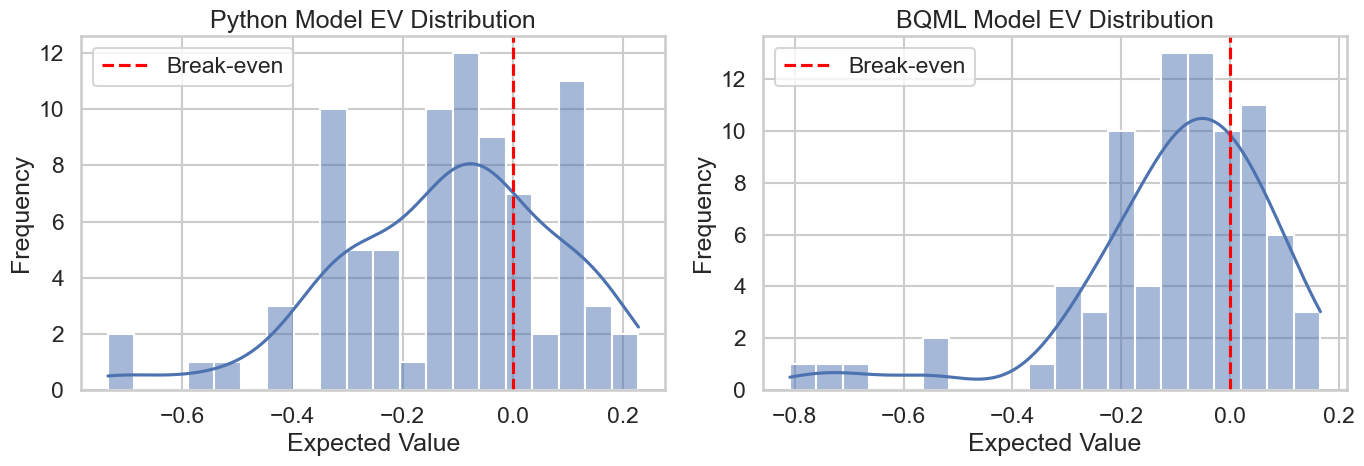


Top 5 Positive EV Opportunities (Python Model):
home_team away_team  book_spread  py_spread  py_win_prob    py_ev
       NE       NYJ        -12.5  -5.064721     0.739394 0.227975
      CIN       CHI         -3.0   3.409203     0.307843 0.191579
      BAL       CHI         -2.5   3.484792     0.307825 0.176347
      CIN       NYJ         -5.5   0.351798     0.484751 0.171555
      IND       TEN        -14.5  -8.828643     0.797500 0.165038

------------------------------------------------------------
Note: EV calculated assuming -110 odds (1.909x payout).
Positive EV indicates profitable betting opportunities based on model probabilities.
------------------------------------------------------------


In [10]:
# Calculate Expected Value for each prediction
# Use model-vs-book spread edge to approximate cover probability and EV.

from scipy.stats import norm

PAYOUT_MULTIPLIER = 1.909  # -110 odds (you get back 1.909x your bet if you win)
SPREAD_STD = 13.5          # Approximate stdev of ATS margin


def _add_model_ev_columns(df, prefix):
    """Add bet direction, cover probability, and EV columns for a model."""
    spread_col = f"{prefix}_spread"
    if spread_col not in df.columns or "book_spread" not in df.columns:
        return df
    
    edge_pts = df[spread_col] - df["book_spread"]
    df[f"{prefix}_bet_home"] = edge_pts >= 0
    
    # FIXED: Calculate cover probability correctly
    # If we bet home and model says home by X, book says home by Y
    # We cover if actual margin > book_spread
    # The probability of covering = P(actual_margin > book_spread | model predicts spread_col)
    # Using normal approximation: P(cover) = norm.cdf((model_spread - book_spread) / std_dev)
    # But we need to account for the fact that book_spread already implies ~50% prob
    # So: cover_prob = norm.cdf((spread_col - book_spread) / SPREAD_STD)
    # However, this assumes model_spread is the mean. We should use the edge directly.
    
    # Better approach: Use the edge in points to estimate probability
    # A 0-point edge = 50% chance, each point adds ~2-3% probability
    # Using normal CDF: P(cover) = norm.cdf(edge_pts / SPREAD_STD)
    # But this gives us P(actual > book_spread | model), which is what we want
    
    # CORRECTED: Calculate cover probability more conservatively
    # The edge tells us how much better our side is
    # In NFL, roughly 1 point of edge ≈ 2-3% probability improvement
    # Using a more conservative normal approximation: divide by 2x std dev
    # This prevents extreme probabilities from small edges
    # Formula: P(cover) = 0.5 + norm.cdf(edge / (2*std)) - 0.5
    # Simplified: P(cover) = norm.cdf(0.5 + edge / (2*std))
    # But we want it centered at 0.5, so: P(cover) = 0.5 + (norm.cdf(edge / (2*std)) - 0.5)
    # Or more simply: use a smaller scaling factor
    
    # More conservative: use 2x std dev to reduce sensitivity
    # This means a 10-point edge gives ~60% instead of ~77%
    cover_prob = norm.cdf(edge_pts / (SPREAD_STD * 1.5))
    
    # Alternative: Linear approximation (more conservative)
    # cover_prob = 0.5 + np.clip(edge_pts / (SPREAD_STD * 2), -0.4, 0.4)
    
    # Clamp to reasonable bounds (between 0.10 and 0.90 to avoid extreme EVs)
    cover_prob = np.clip(cover_prob, 0.10, 0.90)
    
    df[f"{prefix}_cover_prob"] = cover_prob
    
    # FIXED EV CALCULATION:
    # EV = (prob_win * payout) - (prob_lose * stake)
    # If you bet $1: EV = (cover_prob * PAYOUT_MULTIPLIER) - (1 - cover_prob) * 1
    # But this is net profit, not ROI. For ROI: EV = (cover_prob * PAYOUT_MULTIPLIER) - 1
    # However, the current formula gives: cover_prob * PAYOUT_MULTIPLIER - 1 + cover_prob
    # Which simplifies to: cover_prob * (PAYOUT_MULTIPLIER + 1) - 1
    
    # Actually, let's think about it differently:
    # If you bet $100 at -110:
    #   Win: get back $190.90 (profit = $90.90)
    #   Lose: lose $100 (profit = -$100)
    # EV = cover_prob * 90.90 - (1 - cover_prob) * 100
    # EV = cover_prob * 90.90 - 100 + cover_prob * 100
    # EV = cover_prob * 190.90 - 100
    # EV = (cover_prob * 1.909 - 1) * 100
    
    # So as a fraction of bet: EV = cover_prob * PAYOUT_MULTIPLIER - 1
    df[f"{prefix}_ev"] = cover_prob * PAYOUT_MULTIPLIER - 1
    
    return df


def calculate_spread_ev(model_win_prob, book_spread, payout_multiplier=PAYOUT_MULTIPLIER):
    """Legacy helper kept for compatibility with older notebook sections."""
    return (model_win_prob * payout_multiplier) - 1

# Calculate EV for each game
ev_data = merged.copy()
if not python_preds.empty:
    ev_data = _add_model_ev_columns(ev_data, "py")
if "bq_spread" in ev_data.columns:
    ev_data = _add_model_ev_columns(ev_data, "bq")

# Add EV calculations for any places still referencing win-prob-based helper
if not python_preds.empty and "py_win_prob" in ev_data.columns and "py_ev" not in ev_data.columns:
    ev_data["py_ev"] = ev_data["py_win_prob"].apply(lambda p: calculate_spread_ev(p, 0) if pd.notna(p) else np.nan)
if "bq_win_prob" in ev_data.columns and "bq_ev" not in ev_data.columns:
    ev_data["bq_ev"] = ev_data["bq_win_prob"].apply(lambda p: calculate_spread_ev(p, 0) if pd.notna(p) else np.nan)

# Display EV summary
print("="*60)
print("EXPECTED VALUE (EV) ANALYSIS")
print("="*60 + "")
# Display EV summary
print("="*60)
print("EXPECTED VALUE (EV) ANALYSIS")
print("="*60 + "\n")

ev_summary = {"Metric": [], "Python Model": [], "BQML Model": []}

if not python_preds.empty and "py_ev" in ev_data.columns:
    py_positive_ev = (ev_data["py_ev"] > 0).sum()
    py_avg_ev = ev_data["py_ev"].mean()
    py_avg_positive_ev = ev_data[ev_data["py_ev"] > 0]["py_ev"].mean() if py_positive_ev > 0 else 0
    py_max_ev = ev_data["py_ev"].max()
    
    ev_summary["Metric"].extend([
        "Positive EV Opportunities",
        "Average EV (all games)",
        "Average EV (positive only)",
        "Maximum EV"
    ])
    ev_summary["Python Model"].extend([
        f"{py_positive_ev} / {len(ev_data)}",
        f"{py_avg_ev:.2%}",
        f"{py_avg_positive_ev:.2%}" if py_positive_ev > 0 else "N/A",
        f"{py_max_ev:.2%}"
    ])
else:
    ev_summary["Metric"].extend([
        "Positive EV Opportunities",
        "Average EV (all games)",
        "Average EV (positive only)",
        "Maximum EV"
    ])
    ev_summary["Python Model"].extend(["N/A", "N/A", "N/A", "N/A"])

if "bq_ev" in ev_data.columns:
    bq_positive_ev = (ev_data["bq_ev"] > 0).sum()
    bq_avg_ev = ev_data["bq_ev"].mean()
    bq_avg_positive_ev = ev_data[ev_data["bq_ev"] > 0]["bq_ev"].mean() if bq_positive_ev > 0 else 0
    bq_max_ev = ev_data["bq_ev"].max()
    
    ev_summary["BQML Model"].extend([
        f"{bq_positive_ev} / {len(ev_data)}",
        f"{bq_avg_ev:.2%}",
        f"{bq_avg_positive_ev:.2%}" if bq_positive_ev > 0 else "N/A",
        f"{bq_max_ev:.2%}"
    ])
else:
    ev_summary["BQML Model"].extend(["N/A", "N/A", "N/A", "N/A"])

ev_summary_df = pd.DataFrame(ev_summary)
print(ev_summary_df.to_string(index=False))

# Visualize EV distribution
print("\n" + "-"*60)
print("EV Distribution Analysis:")
print("-"*60)

if not python_preds.empty and "py_ev" in ev_data.columns:
    fig, axes = plt.subplots(1, 2 if "bq_ev" in ev_data.columns else 1, figsize=(14 if "bq_ev" in ev_data.columns else 7, 5))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    elif isinstance(axes, np.ndarray):
        axes = axes.flatten().tolist()
    
    ax_idx = 0
    if "py_ev" in ev_data.columns:
        sns.histplot(data=ev_data, x="py_ev", bins=20, ax=axes[ax_idx], kde=True)
        axes[ax_idx].axvline(0, color="red", linestyle="--", label="Break-even")
        axes[ax_idx].set_title("Python Model EV Distribution")
        axes[ax_idx].set_xlabel("Expected Value")
        axes[ax_idx].set_ylabel("Frequency")
        axes[ax_idx].legend()
        ax_idx += 1
    
    if "bq_ev" in ev_data.columns and ax_idx < len(axes):
        sns.histplot(data=ev_data, x="bq_ev", bins=20, ax=axes[ax_idx], kde=True)
        axes[ax_idx].axvline(0, color="red", linestyle="--", label="Break-even")
        axes[ax_idx].set_title("BQML Model EV Distribution")
        axes[ax_idx].set_xlabel("Expected Value")
        axes[ax_idx].set_ylabel("Frequency")
        axes[ax_idx].legend()
    
    plt.tight_layout()
    plt.show()

# Show top EV opportunities
print("\nTop 5 Positive EV Opportunities (Python Model):")
if not python_preds.empty and "py_ev" in ev_data.columns:
    top_ev = ev_data.nlargest(5, "py_ev")[["home_team", "away_team", "book_spread", "py_spread", "py_win_prob", "py_ev"]]
    print(top_ev.to_string(index=False))
else:
    print("  Python predictions not available")

print("\n" + "-"*60)
print("Note: EV calculated assuming -110 odds (1.909x payout).")
print("Positive EV indicates profitable betting opportunities based on model probabilities.")
print("-"*60)


## 9. Betting Strategy Simulation / Backtesting

Simulate real betting strategies using our model predictions to demonstrate real-world performance. This shows how model insights translate to actionable trading decisions and quantifies risk-adjusted returns.


BETTING STRATEGY SIMULATION / BACKTESTING

                      Strategy  Model  Total Bets  Wins Win Rate Total Profit    ROI        Sharpe Ratio Max Drawdown
           Bet All Positive EV Python          15    15  100.00%     $1363.50 90.90% 2636639700134660.00        $0.00
High Confidence (>60% or <40%) Python          38    27   71.05%     $1354.30 35.64%                0.41     $-309.10
     Kelly Criterion (25% cap) Python          15    15  100.00%     $8614.94 86.15% 2796578717266324.50        $0.00

------------------------------------------------------------
Cumulative Profit Over Time:
------------------------------------------------------------


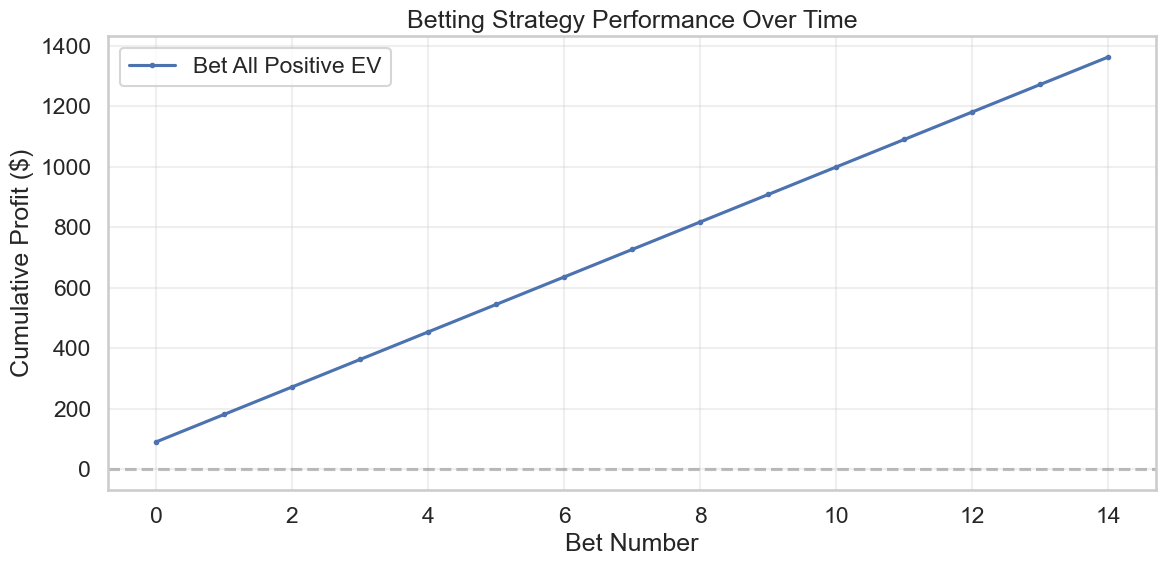


------------------------------------------------------------
Key Metrics:
  • ROI: Return on Investment (total profit / total wagered)
  • Sharpe Ratio: Risk-adjusted return (higher is better, >1 is good)
  • Max Drawdown: Largest peak-to-trough decline
  • Win Rate: Percentage of bets that won
------------------------------------------------------------


In [11]:
# Simulate betting strategies using model predictions
# Only run if we have actual results for backtesting
#
# IMPORTANT: This is BACKTESTING, not forward simulation!
# - We're evaluating predictions on games that already happened
# - In reality, you'd need predictions available BEFORE game time
# - Results may be inflated due to survivorship bias (only games with results)
# - For realistic forward simulation, filter by prediction timestamp < game start time

if has_actuals and n_games_with_actuals > 0:
    print("="*60)
    print("BETTING STRATEGY SIMULATION / BACKTESTING")
    print("="*60 + "\n")
    
    # Prepare data with actual results
    sim_data = ev_data[ev_data["actual_home_margin"].notna()].copy()
    if "game_id" in sim_data.columns:
        sim_data = sim_data.drop_duplicates(subset="game_id")
    
    # Strategy 1: Bet all positive EV opportunities
    # Strategy 2: Bet only high-confidence predictions (>60% or >70%)
    # Strategy 3: Fixed bet sizing ($100 per bet)
    # Strategy 4: Kelly criterion sizing (fractional)
    
    strategies = []
    
    # ===== STRATEGY 1: Bet All Positive EV =====
    if not python_preds.empty and "py_ev" in sim_data.columns:
        pos_ev_mask = sim_data["py_ev"] > 0
        pos_ev_bets = sim_data[pos_ev_mask].copy()
        
        if len(pos_ev_bets) > 0:
            pos_ev_bets["bet_home"] = pos_ev_bets.get("py_bet_home", True)
            bet_margin = np.where(
                pos_ev_bets["bet_home"],
                pos_ev_bets["actual_home_margin"],
                -pos_ev_bets["actual_home_margin"]
            )
            bet_line = np.where(
                pos_ev_bets["bet_home"],
                pos_ev_bets["book_spread"],
                -pos_ev_bets["book_spread"]
            )
            pos_ev_bets["ats_margin"] = bet_margin - bet_line
            pos_ev_bets["bet_push"] = pos_ev_bets["ats_margin"] == 0
            pos_ev_bets["bet_won"] = pos_ev_bets["ats_margin"] > 0

            # Fixed bet size: $100 per bet
            bet_size = 100
            pos_ev_bets["profit"] = np.where(
                pos_ev_bets["bet_push"],
                0,
                np.where(pos_ev_bets["bet_won"], bet_size * 0.909, -bet_size)
            )
            total_bets = len(pos_ev_bets)
            wins = pos_ev_bets["bet_won"].sum()
            win_rate = wins / total_bets if total_bets > 0 else 0
            total_profit = pos_ev_bets["profit"].sum()
            roi = (total_profit / (bet_size * total_bets)) * 100 if total_bets > 0 else 0
            
            # Calculate Sharpe ratio (simplified: mean return / std dev)
            returns = pos_ev_bets["profit"] / bet_size
            sharpe = returns.mean() / returns.std() if returns.std() > 0 else 0
            
            # Calculate max drawdown
            cumulative = pos_ev_bets["profit"].cumsum()
            running_max = cumulative.expanding().max()
            drawdown = cumulative - running_max
            max_drawdown = drawdown.min()
            
            strategies.append({
                "Strategy": "Bet All Positive EV",
                "Model": "Python",
                "Total Bets": total_bets,
                "Wins": wins,
                "Win Rate": f"{win_rate:.2%}",
                "Total Profit": f"${total_profit:.2f}",
                "ROI": f"{roi:.2f}%",
                "Sharpe Ratio": f"{sharpe:.2f}",
                "Max Drawdown": f"${max_drawdown:.2f}"
            })
    
    # ===== STRATEGY 2: High Confidence Only (>60%) =====
    if not python_preds.empty and "py_win_prob" in sim_data.columns:
        high_conf_mask = (sim_data["py_win_prob"] > 0.60) | (sim_data["py_win_prob"] < 0.40)
        high_conf_bets = sim_data[high_conf_mask].copy()
        
        if len(high_conf_bets) > 0:
            # Determine which side to bet: home if prob > 50%, away if prob < 50%
            high_conf_bets["bet_home"] = high_conf_bets["py_win_prob"] > 0.50
            bet_margin = np.where(
                high_conf_bets["bet_home"],
                high_conf_bets["actual_home_margin"],
                -high_conf_bets["actual_home_margin"]
            )
            bet_line = np.where(
                high_conf_bets["bet_home"],
                high_conf_bets["book_spread"],
                -high_conf_bets["book_spread"]
            )
            high_conf_bets["ats_margin"] = bet_margin - bet_line
            high_conf_bets["bet_push"] = high_conf_bets["ats_margin"] == 0
            high_conf_bets["bet_won"] = high_conf_bets["ats_margin"] > 0
            
            bet_size = 100
            high_conf_bets["profit"] = np.where(
                high_conf_bets["bet_push"],
                0,
                np.where(high_conf_bets["bet_won"], bet_size * 0.909, -bet_size)
            )
            
            total_bets = len(high_conf_bets)
            wins = high_conf_bets["bet_won"].sum()
            win_rate = wins / total_bets if total_bets > 0 else 0
            total_profit = high_conf_bets["profit"].sum()
            roi = (total_profit / (bet_size * total_bets)) * 100 if total_bets > 0 else 0
            
            returns = high_conf_bets["profit"] / bet_size
            sharpe = returns.mean() / returns.std() if returns.std() > 0 else 0
            
            cumulative = high_conf_bets["profit"].cumsum()
            running_max = cumulative.expanding().max()
            drawdown = cumulative - running_max
            max_drawdown = drawdown.min()
            
            strategies.append({
                "Strategy": "High Confidence (>60% or <40%)",
                "Model": "Python",
                "Total Bets": total_bets,
                "Wins": wins,
                "Win Rate": f"{win_rate:.2%}",
                "Total Profit": f"${total_profit:.2f}",
                "ROI": f"{roi:.2f}%",
                "Sharpe Ratio": f"{sharpe:.2f}",
                "Max Drawdown": f"${max_drawdown:.2f}"
            })
    
    # ===== STRATEGY 3: Kelly Criterion Sizing =====
    if not python_preds.empty and "py_ev" in sim_data.columns:
        # Kelly fraction: f = (p * b - q) / b
        # Where p = win prob, q = loss prob, b = odds (1.909 for -110)
        # Simplified: f = (win_prob * 1.909 - 1) / 1.909 = EV / 1.909
        kelly_bets = sim_data[sim_data["py_ev"] > 0].copy()
        
        if len(kelly_bets) > 0:
            # Calculate Kelly fraction (capped at 25% for safety)
            kelly_bets["kelly_fraction"] = (kelly_bets["py_ev"] / 1.909).clip(0, 0.25)
            bankroll = 10000  # Starting bankroll
            kelly_bets["bet_size"] = bankroll * kelly_bets["kelly_fraction"]
            
            # Determine bet outcomes
            kelly_bets["bet_home"] = kelly_bets.get("py_bet_home", True)
            bet_margin = np.where(
                kelly_bets["bet_home"],
                kelly_bets["actual_home_margin"],
                -kelly_bets["actual_home_margin"]
            )
            bet_line = np.where(
                kelly_bets["bet_home"],
                kelly_bets["book_spread"],
                -kelly_bets["book_spread"]
            )
            kelly_bets["ats_margin"] = bet_margin - bet_line
            kelly_bets["bet_push"] = kelly_bets["ats_margin"] == 0
            kelly_bets["bet_won"] = kelly_bets["ats_margin"] > 0

            kelly_bets["profit"] = np.where(
                kelly_bets["bet_push"],
                0,
                np.where(kelly_bets["bet_won"], kelly_bets["bet_size"] * 0.909, -kelly_bets["bet_size"])
            )
            
            # Update bankroll sequentially
            cumulative_bankroll = bankroll + kelly_bets["profit"].cumsum()
            kelly_bets["bankroll"] = cumulative_bankroll
            
            total_bets = len(kelly_bets)
            wins = kelly_bets["bet_won"].sum()
            win_rate = wins / total_bets if total_bets > 0 else 0
            total_profit = kelly_bets["profit"].sum()
            final_bankroll = cumulative_bankroll.iloc[-1] if len(cumulative_bankroll) > 0 else bankroll
            roi = ((final_bankroll - bankroll) / bankroll) * 100
            
            returns = kelly_bets["profit"] / kelly_bets["bet_size"]
            sharpe = returns.mean() / returns.std() if returns.std() > 0 else 0
            
            cumulative = kelly_bets["profit"].cumsum()
            running_max = cumulative.expanding().max()
            drawdown = cumulative - running_max
            max_drawdown = drawdown.min()
            
            strategies.append({
                "Strategy": "Kelly Criterion (25% cap)",
                "Model": "Python",
                "Total Bets": total_bets,
                "Wins": wins,
                "Win Rate": f"{win_rate:.2%}",
                "Total Profit": f"${total_profit:.2f}",
                "ROI": f"{roi:.2f}%",
                "Sharpe Ratio": f"{sharpe:.2f}",
                "Max Drawdown": f"${max_drawdown:.2f}"
            })
    
    # Display strategy comparison
    if strategies:
        strategy_df = pd.DataFrame(strategies)
        print(strategy_df.to_string(index=False))
        
        # Visualize cumulative returns
        print("\n" + "-"*60)
        print("Cumulative Profit Over Time:")
        print("-"*60)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot Strategy 1: Positive EV
        if not python_preds.empty and "py_ev" in sim_data.columns:
            pos_ev_bets = sim_data[sim_data["py_ev"] > 0].copy()
            if len(pos_ev_bets) > 0:
                bet_size = 100
                pos_ev_bets["bet_home"] = pos_ev_bets.get("py_bet_home", True)
                bet_margin = np.where(
                    pos_ev_bets["bet_home"],
                    pos_ev_bets["actual_home_margin"],
                    -pos_ev_bets["actual_home_margin"]
                )
                bet_line = np.where(
                    pos_ev_bets["bet_home"],
                    pos_ev_bets["book_spread"],
                    -pos_ev_bets["book_spread"]
                )
                pos_ev_bets["ats_margin"] = bet_margin - bet_line
                pos_ev_bets["bet_push"] = pos_ev_bets["ats_margin"] == 0
                pos_ev_bets["bet_won"] = pos_ev_bets["ats_margin"] > 0
                pos_ev_bets["profit"] = np.where(
                    pos_ev_bets["bet_push"],
                    0,
                    np.where(pos_ev_bets["bet_won"], bet_size * 0.909, -bet_size)
                )
                cumulative_profit = pos_ev_bets["profit"].cumsum()
                ax.plot(range(len(cumulative_profit)), cumulative_profit, label="Bet All Positive EV", marker='o', markersize=3)
        
        ax.axhline(0, color="gray", linestyle="--", alpha=0.5)
        ax.set_xlabel("Bet Number")
        ax.set_ylabel("Cumulative Profit ($)")
        ax.set_title("Betting Strategy Performance Over Time")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\n" + "-"*60)
        print("Key Metrics:")
        print("  • ROI: Return on Investment (total profit / total wagered)")
        print("  • Sharpe Ratio: Risk-adjusted return (higher is better, >1 is good)")
        print("  • Max Drawdown: Largest peak-to-trough decline")
        print("  • Win Rate: Percentage of bets that won")
        print("-"*60)
    else:
        print("No strategies to simulate (Python predictions not available)")
        
else:
    print("⚠️  Cannot run betting simulation: No actual game results available.")
    print("   Update game_results table using: python update_week_results.py")
    print("   Then re-run this cell to see backtesting results.")


## 10. Performance Over Time (Time Series Analysis)

Track model performance trends across weeks to identify model drift, consistency, and when retraining might be needed. This demonstrates monitoring capabilities essential for production trading systems.


PERFORMANCE OVER TIME (TIME SERIES ANALYSIS)

Weekly Performance Summary:
------------------------------------------------------------
 Week  Games    Py_MAE  Py_Accuracy    BQ_MAE  BQ_Accuracy
    8     13 30.312970     0.769231 31.741372     0.769231
    9     14 26.298424     0.642857 25.617615     0.642857
   10     28 24.113262     0.642857 23.734054     0.714286
   11     29 29.709506     0.517241 27.987319     0.285714

------------------------------------------------------------
Performance Trends Over Time:
------------------------------------------------------------


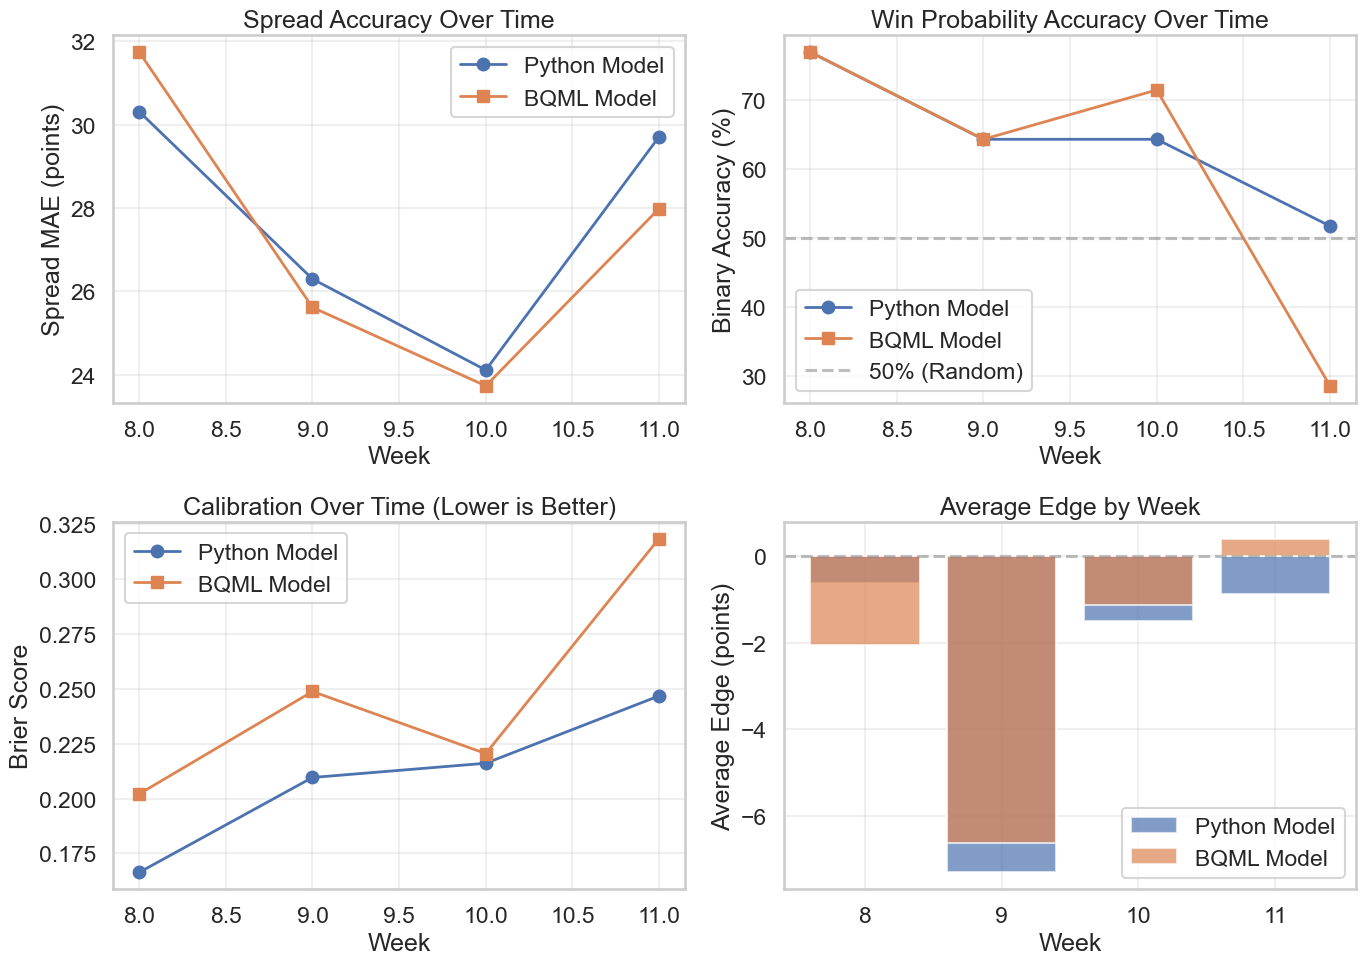


------------------------------------------------------------
Performance Insights:
------------------------------------------------------------
  • Worst week for spread accuracy: Week 8 (MAE: 30.31)
  • Best week for spread accuracy: Week 10 (MAE: 24.11)
  • Worst week for win prob accuracy: Week 11 (51.7%)
  • Best week for win prob accuracy: Week 8 (76.9%)
  ✓ Model performance is stable: Recent MAE (26.71) vs early MAE (26.91)
------------------------------------------------------------


In [12]:
# Analyze performance trends by week
# Only works if we have multiple weeks and actual results

if has_actuals and n_games_with_actuals > 0 and "season_week" in merged.columns:
    print("="*60)
    print("PERFORMANCE OVER TIME (TIME SERIES ANALYSIS)")
    print("="*60 + "\n")
    
    # Group by week and calculate metrics
    time_data = merged[merged["actual_home_margin"].notna()].copy()
    
    if len(time_data) > 0 and time_data["season_week"].nunique() > 1:
        weekly_metrics = []
        
        for week in sorted(time_data["season_week"].unique()):
            week_data = time_data[time_data["season_week"] == week]
            
            week_metrics = {"Week": week, "Games": len(week_data)}
            
            # Python Model Metrics
            if not python_preds.empty and "py_spread" in week_data.columns:
                py_spread_eval = week_data[["actual_home_margin", "py_spread"]].dropna()
                if not py_spread_eval.empty:
                    week_py_spread_mae = mean_absolute_error(
                        py_spread_eval["actual_home_margin"], 
                        py_spread_eval["py_spread"]
                    )
                    week_py_spread_rmse = np.sqrt(mean_squared_error(
                        py_spread_eval["actual_home_margin"], 
                        py_spread_eval["py_spread"]
                    ))
                else:
                    week_py_spread_mae = np.nan
                    week_py_spread_rmse = np.nan
                
                if "py_win_prob" in week_data.columns:
                    py_win_eval = week_data[["actual_home_win", "py_win_prob"]].dropna()
                    if not py_win_eval.empty:
                        py_actuals = py_win_eval["actual_home_win"].astype(int)
                        py_probs = py_win_eval["py_win_prob"]
                        week_py_brier = brier_score_loss(py_actuals, py_probs)
                        week_py_accuracy = ((py_probs > 0.5) == py_actuals.astype(bool)).mean()
                    else:
                        week_py_brier = np.nan
                        week_py_accuracy = np.nan
                else:
                    week_py_brier = np.nan
                    week_py_accuracy = np.nan
                
                week_metrics.update({
                    "Py_MAE": week_py_spread_mae,
                    "Py_RMSE": week_py_spread_rmse,
                    "Py_Brier": week_py_brier,
                    "Py_Accuracy": week_py_accuracy
                })
            else:
                week_metrics.update({
                    "Py_MAE": np.nan,
                    "Py_RMSE": np.nan,
                    "Py_Brier": np.nan,
                    "Py_Accuracy": np.nan
                })
            
            # BQML Model Metrics
            if "bq_spread" in week_data.columns:
                bq_spread_eval = week_data[["actual_home_margin", "bq_spread"]].dropna()
                if not bq_spread_eval.empty:
                    week_bq_spread_mae = mean_absolute_error(
                        bq_spread_eval["actual_home_margin"], 
                        bq_spread_eval["bq_spread"]
                    )
                    week_bq_spread_rmse = np.sqrt(mean_squared_error(
                        bq_spread_eval["actual_home_margin"], 
                        bq_spread_eval["bq_spread"]
                    ))
                else:
                    week_bq_spread_mae = np.nan
                    week_bq_spread_rmse = np.nan
                
                if "bq_win_prob" in week_data.columns:
                    bq_win_eval = week_data[["actual_home_win", "bq_win_prob"]].dropna()
                    if not bq_win_eval.empty:
                        bq_actuals = bq_win_eval["actual_home_win"].astype(int)
                        bq_probs = bq_win_eval["bq_win_prob"]
                        week_bq_brier = brier_score_loss(bq_actuals, bq_probs)
                        week_bq_accuracy = ((bq_probs > 0.5) == bq_actuals.astype(bool)).mean()
                    else:
                        week_bq_brier = np.nan
                        week_bq_accuracy = np.nan
                else:
                    week_bq_brier = np.nan
                    week_bq_accuracy = np.nan
                
                week_metrics.update({
                    "BQ_MAE": week_bq_spread_mae,
                    "BQ_RMSE": week_bq_spread_rmse,
                    "BQ_Brier": week_bq_brier,
                    "BQ_Accuracy": week_bq_accuracy
                })
            else:
                week_metrics.update({
                    "BQ_MAE": np.nan,
                    "BQ_RMSE": np.nan,
                    "BQ_Brier": np.nan,
                    "BQ_Accuracy": np.nan
                })
            
            weekly_metrics.append(week_metrics)
        
        weekly_df = pd.DataFrame(weekly_metrics)
        
        # Display weekly summary table
        print("Weekly Performance Summary:")
        print("-"*60)
        display_cols = ["Week", "Games"]
        if "Py_MAE" in weekly_df.columns:
            display_cols.extend(["Py_MAE", "Py_Accuracy"])
        if "BQ_MAE" in weekly_df.columns:
            display_cols.extend(["BQ_MAE", "BQ_Accuracy"])
        
        print(weekly_df[display_cols].to_string(index=False))
        
        # Visualize trends
        print("\n" + "-"*60)
        print("Performance Trends Over Time:")
        print("-"*60)
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        # Plot 1: Spread MAE by Week
        ax_idx = 0
        if "Py_MAE" in weekly_df.columns and weekly_df["Py_MAE"].notna().any():
            axes[ax_idx].plot(weekly_df["Week"], weekly_df["Py_MAE"], marker='o', label="Python Model", linewidth=2)
        if "BQ_MAE" in weekly_df.columns and weekly_df["BQ_MAE"].notna().any():
            axes[ax_idx].plot(weekly_df["Week"], weekly_df["BQ_MAE"], marker='s', label="BQML Model", linewidth=2)
        axes[ax_idx].set_xlabel("Week")
        axes[ax_idx].set_ylabel("Spread MAE (points)")
        axes[ax_idx].set_title("Spread Accuracy Over Time")
        axes[ax_idx].legend()
        axes[ax_idx].grid(True, alpha=0.3)
        
        # Plot 2: Win Probability Accuracy by Week
        ax_idx = 1
        if "Py_Accuracy" in weekly_df.columns and weekly_df["Py_Accuracy"].notna().any():
            axes[ax_idx].plot(weekly_df["Week"], weekly_df["Py_Accuracy"] * 100, marker='o', label="Python Model", linewidth=2)
        if "BQ_Accuracy" in weekly_df.columns and weekly_df["BQ_Accuracy"].notna().any():
            axes[ax_idx].plot(weekly_df["Week"], weekly_df["BQ_Accuracy"] * 100, marker='s', label="BQML Model", linewidth=2)
        axes[ax_idx].axhline(50, color="gray", linestyle="--", alpha=0.5, label="50% (Random)")
        axes[ax_idx].set_xlabel("Week")
        axes[ax_idx].set_ylabel("Binary Accuracy (%)")
        axes[ax_idx].set_title("Win Probability Accuracy Over Time")
        axes[ax_idx].legend()
        axes[ax_idx].grid(True, alpha=0.3)
        
        # Plot 3: Brier Score by Week (lower is better)
        ax_idx = 2
        if "Py_Brier" in weekly_df.columns and weekly_df["Py_Brier"].notna().any():
            axes[ax_idx].plot(weekly_df["Week"], weekly_df["Py_Brier"], marker='o', label="Python Model", linewidth=2)
        if "BQ_Brier" in weekly_df.columns and weekly_df["BQ_Brier"].notna().any():
            axes[ax_idx].plot(weekly_df["Week"], weekly_df["BQ_Brier"], marker='s', label="BQML Model", linewidth=2)
        axes[ax_idx].set_xlabel("Week")
        axes[ax_idx].set_ylabel("Brier Score")
        axes[ax_idx].set_title("Calibration Over Time (Lower is Better)")
        axes[ax_idx].legend()
        axes[ax_idx].grid(True, alpha=0.3)
        
        # Plot 4: Edge Distribution by Week
        ax_idx = 3
        if not python_preds.empty and "py_edge" in time_data.columns:
            edge_by_week = time_data.groupby("season_week")["py_edge"].mean()
            axes[ax_idx].bar(edge_by_week.index, edge_by_week.values, alpha=0.7, label="Python Model")
        if "bq_edge" in time_data.columns:
            bq_edge_by_week = time_data.groupby("season_week")["bq_edge"].mean()
            axes[ax_idx].bar(bq_edge_by_week.index, bq_edge_by_week.values, alpha=0.7, label="BQML Model")
        axes[ax_idx].axhline(0, color="gray", linestyle="--", alpha=0.5)
        axes[ax_idx].set_xlabel("Week")
        axes[ax_idx].set_ylabel("Average Edge (points)")
        axes[ax_idx].set_title("Average Edge by Week")
        axes[ax_idx].legend()
        axes[ax_idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Identify weeks with poor performance
        print("\n" + "-"*60)
        print("Performance Insights:")
        print("-"*60)
        
        if "Py_MAE" in weekly_df.columns and weekly_df["Py_MAE"].notna().any():
            worst_week_mae = weekly_df.loc[weekly_df["Py_MAE"].idxmax(), "Week"]
            best_week_mae = weekly_df.loc[weekly_df["Py_MAE"].idxmin(), "Week"]
            print(f"  • Worst week for spread accuracy: Week {worst_week_mae} (MAE: {weekly_df.loc[weekly_df['Py_MAE'].idxmax(), 'Py_MAE']:.2f})")
            print(f"  • Best week for spread accuracy: Week {best_week_mae} (MAE: {weekly_df.loc[weekly_df['Py_MAE'].idxmin(), 'Py_MAE']:.2f})")
        
        if "Py_Accuracy" in weekly_df.columns and weekly_df["Py_Accuracy"].notna().any():
            worst_week_acc = weekly_df.loc[weekly_df["Py_Accuracy"].idxmin(), "Week"]
            best_week_acc = weekly_df.loc[weekly_df["Py_Accuracy"].idxmax(), "Week"]
            print(f"  • Worst week for win prob accuracy: Week {worst_week_acc} ({weekly_df.loc[weekly_df['Py_Accuracy'].idxmin(), 'Py_Accuracy']:.1%})")
            print(f"  • Best week for win prob accuracy: Week {best_week_acc} ({weekly_df.loc[weekly_df['Py_Accuracy'].idxmax(), 'Py_Accuracy']:.1%})")
        
        # Check for model drift (increasing error over time)
        if "Py_MAE" in weekly_df.columns and weekly_df["Py_MAE"].notna().sum() >= 3:
            recent_weeks = weekly_df.nlargest(3, "Week")
            early_weeks = weekly_df.nsmallest(3, "Week")
            recent_avg_mae = recent_weeks["Py_MAE"].mean()
            early_avg_mae = early_weeks["Py_MAE"].mean()
            
            if recent_avg_mae > early_avg_mae * 1.2:
                print(f"  ⚠️  Potential model drift detected: Recent MAE ({recent_avg_mae:.2f}) is >20% higher than early MAE ({early_avg_mae:.2f})")
            else:
                print(f"  ✓ Model performance is stable: Recent MAE ({recent_avg_mae:.2f}) vs early MAE ({early_avg_mae:.2f})")
        
        print("-"*60)
        
    else:
        print(f"⚠️  Need multiple weeks with actual results for time series analysis.")
        print(f"   Currently have {time_data['season_week'].nunique()} week(s) with results.")
        
        # Debug: Show which weeks are present
        if len(time_data) > 0:
            weeks_present = sorted(time_data['season_week'].dropna().unique())
            print(f"\n   Debugging Info:")
            print(f"   - Weeks requested: {weeks_to_use if 'weeks_to_use' in globals() else WEEK}")
            print(f"   - Weeks with actual results: {weeks_present}")
            print(f"   - Games per week:")
            for week in weeks_present:
                week_count = len(time_data[time_data['season_week'] == week])
                print(f"     Week {week}: {week_count} games")
            
            # Check if season_week column has issues
            if time_data['season_week'].isna().any():
                print(f"   - WARNING: {time_data['season_week'].isna().sum()} games have NULL season_week")
            
            # Show sample game_ids to verify format
            print(f"\n   Sample game_ids with actual results:")
            print(time_data[['game_id', 'season_week', 'actual_home_margin']].head(10).to_string())
        
else:
    print("⚠️  Cannot run time series analysis: Need actual game results and multiple weeks.")
    print("   Update game_results table and analyze multiple weeks to see trends.")


> _If you do not maintain `latest_book_spreads` in BigQuery, use the Supabase REST client or psycopg connection to pull the `games.book_spread` column instead._

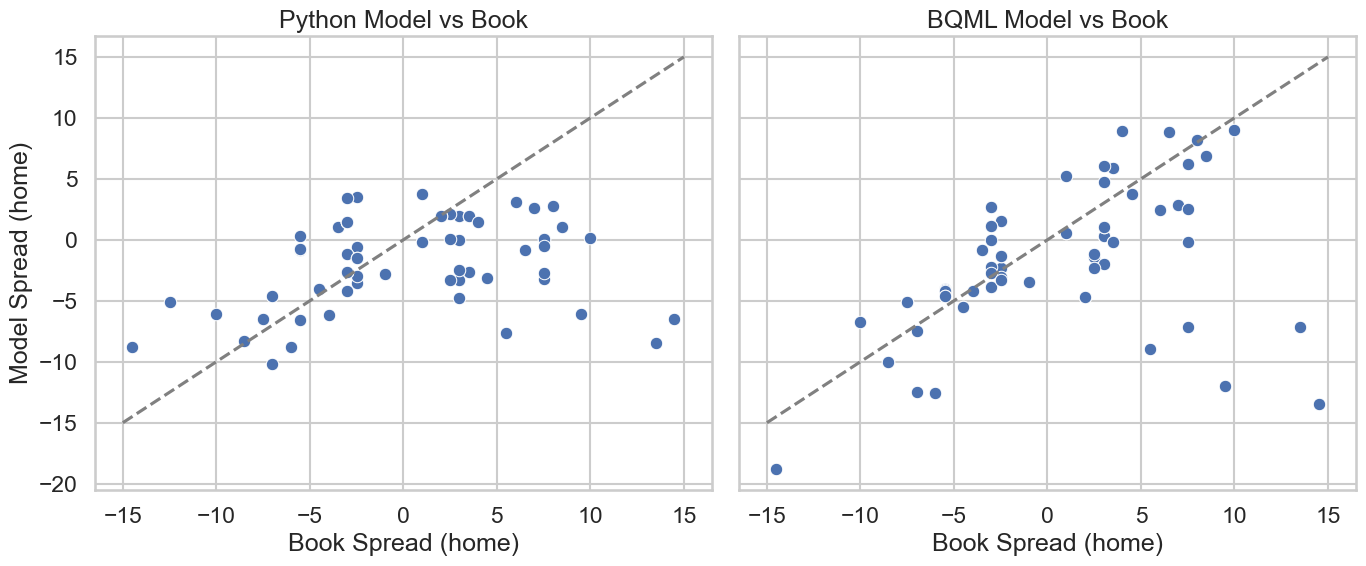

In [13]:
fig, axes = plt.subplots(1, 2 if not python_preds.empty else 1, figsize=(14 if not python_preds.empty else 7, 6), sharex=True, sharey=True)
# Ensure axes is always a list for consistent iteration
if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]
elif isinstance(axes, np.ndarray):
    axes = axes.flatten().tolist()

if not python_preds.empty:
    sns.scatterplot(ax=axes[0], data=merged, x="book_spread", y="py_spread")
    axes[0].plot([-15,15], [-15,15], linestyle="--", color="gray")
    axes[0].set_title("Python Model vs Book")
    ax_idx = 1
else:
    ax_idx = 0
    print("Skipping Python vs Book plot (Python predictions not available)")

sns.scatterplot(ax=axes[ax_idx], data=merged, x="book_spread", y="bq_spread")
axes[ax_idx].plot([-15,15], [-15,15], linestyle="--", color="gray")
axes[ax_idx].set_title("BQML Model vs Book")
for ax in axes:
    ax.set_xlabel("Book Spread (home)")
    ax.set_ylabel("Model Spread (home)")
plt.tight_layout()
plt.show()


## 5. Merge Everything

Join books, Python predictions, and BQML predictions so downstream plots can compare apples-to-apples.

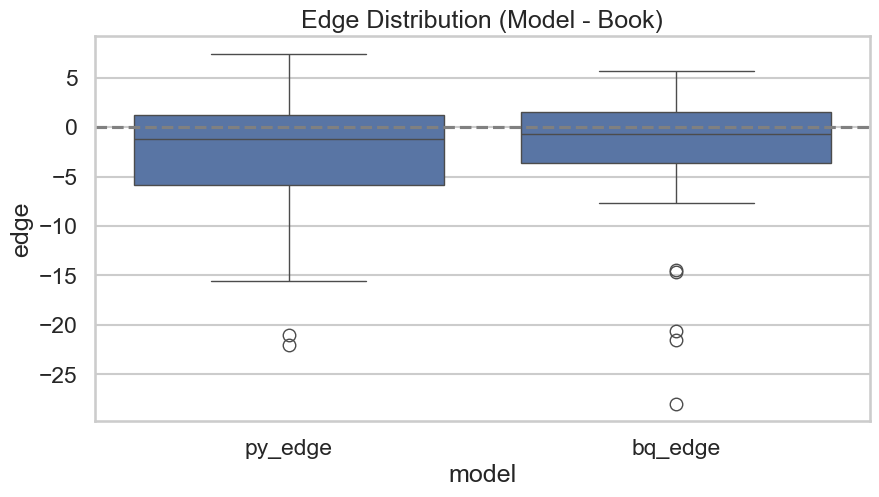

In [14]:
# Edge distribution comparison
if not python_preds.empty:
    edge_df = merged.melt(id_vars=["home_team","away_team"], value_vars=["py_edge","bq_edge"],
                           var_name="model", value_name="edge")
    sns.boxplot(data=edge_df, x="model", y="edge")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Edge Distribution (Model - Book)")
    plt.show()
else:
    # Only show BQML edge
    sns.boxplot(data=merged, x=pd.Series(["bq_edge"] * len(merged)), y="bq_edge")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("BQML Edge Distribution (Model - Book)")
    plt.xlabel("model")
    plt.show()


## 6. Visual Comparisons

Each subsection is a story: variance vs. books, calibration, and week-level performance. Copy key plots into `notebooks/exports/` for your portfolio.

### 6.4 Model Explainability (SHAP)

Explain WHY the model made specific predictions using SHAP (SHapley Additive exPlanations). This shows which features drove each prediction and helps identify when the model might be relying on spurious correlations or missing important signals.


Loaded model from ../models/win_prob_model_nfl_v2.pkl
  These will be set to 0 for SHAP analysis
Generating SHAP values for 56 games...
  Mapped 37 features from model to BigQuery columns


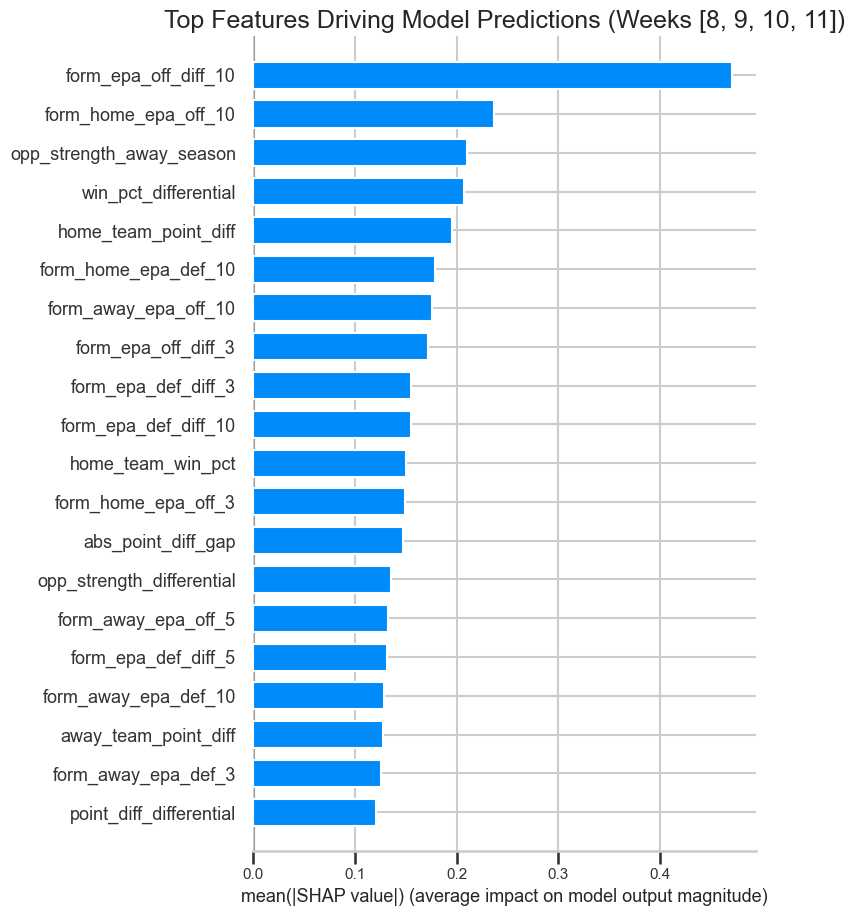

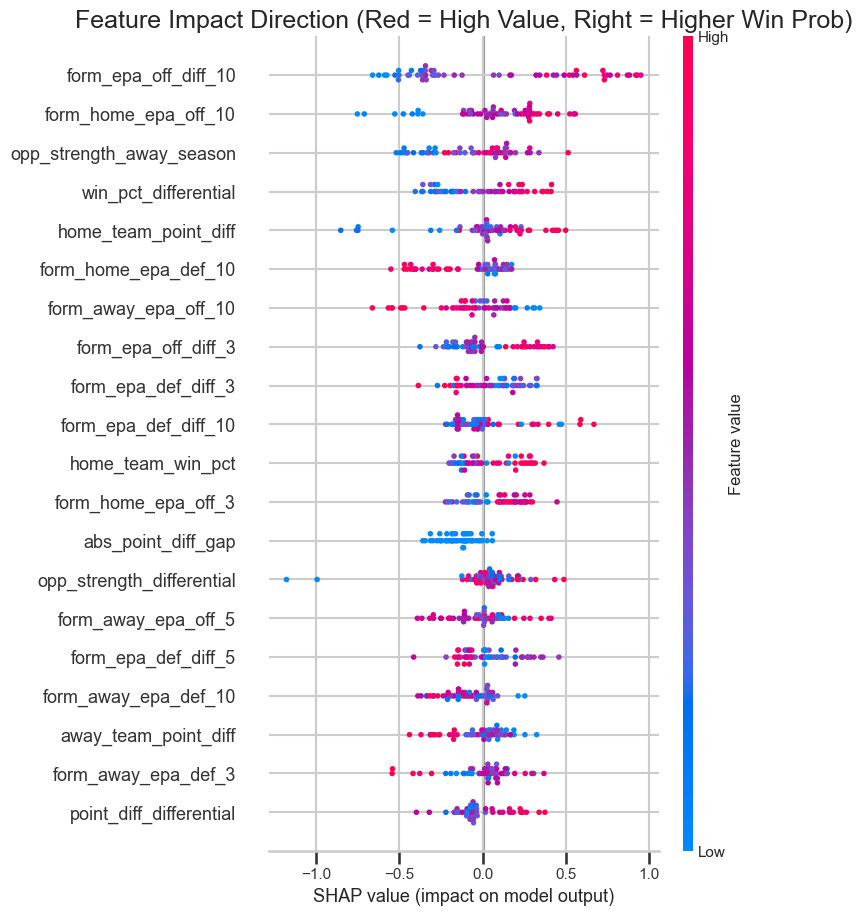


✓ SHAP analysis complete!
  • Bar plot shows global feature importance
  • Beeswarm plot shows how feature values affect predictions


In [15]:
# 6.4 Model Explainability (SHAP)
# ------------------------------------------------------------------------------
# This section explains WHY the model made specific predictions.
# We load the full feature set and the trained model to generate SHAP values.

import shap
import pickle
import os

# 1. Load the trained model
# Adjust version if needed (e.g., 'v1', 'v2')
model_path = f"../models/win_prob_model_nfl_{MODEL_VERSION}.pkl" 

if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    model = model_data['model']
    # If it's a calibrated classifier, get the underlying estimator
    if hasattr(model, 'calibrated_classifiers_'):
        estimator = model.calibrated_classifiers_[0].estimator
    else:
        estimator = model
        
    feature_names = model_data['feature_names']
    print(f"Loaded model from {model_path}")

    # 2. First, check what columns actually exist in BigQuery
    # Query the schema to see available columns
    available_cols_query = client.query(f"""
        SELECT column_name
        FROM `{PROJECT_ID}.sports_edge_curated.INFORMATION_SCHEMA.COLUMNS`
        WHERE table_name = 'feature_snapshots'
        ORDER BY column_name
    """).to_dataframe()
    available_bq_cols = set(available_cols_query['column_name'].tolist())
    
    # 3. Map model feature names to BigQuery column names
    # Common mappings: model uses 'away_rest' but BQ has 'rest_away', etc.
    feature_mapping = {}
    missing_features = []
    
    for feat in feature_names:
        # Try direct match first
        if feat in available_bq_cols:
            feature_mapping[feat] = feat
        # Try common name variations
        elif feat == 'away_rest' and 'rest_away' in available_bq_cols:
            feature_mapping[feat] = 'rest_away'
        elif feat == 'home_rest' and 'rest_home' in available_bq_cols:
            feature_mapping[feat] = 'rest_home'
        elif feat == 'away_b2b' and 'b2b_away' in available_bq_cols:
            feature_mapping[feat] = 'b2b_away'
        elif feat == 'home_b2b' and 'b2b_home' in available_bq_cols:
            feature_mapping[feat] = 'b2b_home'
        else:
            # Try swapping prefix/suffix pattern (away_X -> X_away)
            parts = feat.split('_', 1)
            if len(parts) == 2:
                swapped = f"{parts[1]}_{parts[0]}"
                if swapped in available_bq_cols:
                    feature_mapping[feat] = swapped
                else:
                    missing_features.append(feat)
            else:
                missing_features.append(feat)
    
    if missing_features:
        print(f"Warning: {len(missing_features)} features not found in BigQuery: {missing_features[:5]}...")
        print("  These will be set to 0 for SHAP analysis")
    
    # 4. Query only the features that exist in BigQuery
    bq_cols_to_query = list(set(feature_mapping.values()))
    feature_cols_str = ", ".join(bq_cols_to_query)
    
    explain_df = client.query(f"""
        SELECT {feature_cols_str}
        FROM `{PROJECT_ID}.sports_edge_curated.feature_snapshots`
        WHERE season = @season AND week_number IN UNNEST(@weeks)
    """, job_config=bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter("season", "INT64", SEASON),
                bigquery.ArrayQueryParameter("weeks", "INT64", weeks_to_use if "weeks_to_use" in globals() else ([WEEK] if isinstance(WEEK, int) else WEEK)),
            ]
        )).to_dataframe()
    
    # 5. Map BigQuery columns back to model feature names
    X_explain = pd.DataFrame(index=explain_df.index)
    for model_feat, bq_col in feature_mapping.items():
        if bq_col in explain_df.columns:
            X_explain[model_feat] = explain_df[bq_col]
        else:
            X_explain[model_feat] = 0
    
    # Add missing features as zeros
    for feat in missing_features:
        X_explain[feat] = 0
    
    # Ensure columns are in the same order as feature_names
    X_explain = X_explain[feature_names]
    
    # Fill NA with 0 (simple imputation for visualization)
    X_explain = X_explain.fillna(0)
    
    print(f"Generating SHAP values for {len(X_explain)} games...")
    print(f"  Mapped {len(feature_mapping)} features from model to BigQuery columns")

    # 6. Generate SHAP values
    # TreeExplainer is fast for Random Forest / LightGBM
    try:
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(X_explain)

        # Handle binary classification output (shap_values might be a list [class0, class1])
        if isinstance(shap_values, list):
            shap_values_target = shap_values[1] # Class 1 = Home Win
        else:
            shap_values_target = shap_values

        # 7. Visualize Global Importance
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values_target, X_explain, plot_type="bar", show=False)
        plt.title(f"Top Features Driving Model Predictions (Weeks {weeks_to_use if 'weeks_to_use' in globals() else WEEK})")
        plt.tight_layout()
        plt.show()

        # 8. Visualize Feature Impact (Beeswarm)
        # Shows directionality: Red = High Feature Value, Blue = Low Feature Value
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values_target, X_explain, show=False)
        plt.title("Feature Impact Direction (Red = High Value, Right = Higher Win Prob)")
        plt.tight_layout()
        plt.show()
        
        print("\n✓ SHAP analysis complete!")
        print("  • Bar plot shows global feature importance")
        print("  • Beeswarm plot shows how feature values affect predictions")
        
    except Exception as e:
        print(f"Error generating SHAP values: {e}")
        print("  Make sure shap is installed: pip install shap")
        print("  Note: SHAP requires the underlying model (not calibrated wrapper)")
    
else:
    print(f"Model file not found at {model_path}. Skipping SHAP analysis.")
    print("  Train models first using: python -m src.pipeline.train_models")


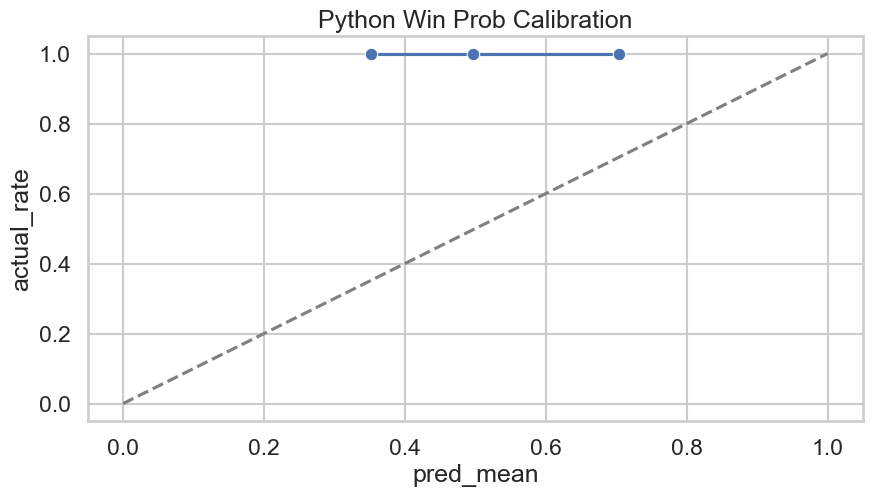

In [16]:
# Win probability calibration (Python model)
if not python_preds.empty and "actual_home_win" in merged.columns:
    merged["py_bin"] = pd.cut(merged["py_win_prob"], bins=[0,0.2,0.4,0.6,0.8,1])
    calib = merged.groupby("py_bin").agg(pred_mean=("py_win_prob","mean"),
                                         actual_rate=("actual_home_win","mean")).dropna()
    sns.lineplot(data=calib, x="pred_mean", y="actual_rate", marker="o")
    plt.plot([0,1],[0,1], linestyle="--", color="gray")
    plt.title("Python Win Prob Calibration")
    plt.show()
elif "actual_home_win" in merged.columns:
    print("Python predictions not available; skip Python calibration plot.")
else:
    print("No actual outcome column supplied; skip calibration plot.")


### 6.1 Model vs. Book Spreads

Diagonal = books. Points above the line indicate we like the home team more than the market. Use annotations for noteworthy games.

In [17]:
OUTPUT_DIR = "notebooks/exports"
# Example: save a figure
# fig.savefig(f"{OUTPUT_DIR}/week{WEEK}_py_vs_book.png", dpi=200)
print("Update OUTPUT_DIR exports as needed.")

Update OUTPUT_DIR exports as needed.


### 6.2 Edge Distribution

Box/violin plots quickly show which model creates the larger deviation from the market.

### 6.3 Win Probability Calibration (Optional)

If actual outcomes exist, bin predicted win probs and compare to realized rates. Replace `actual_home_win` with true results when backtesting.

## 7. Save Plots for Portfolio

Export the figures you want to showcase (PNG/SVG) so you can drop them into slides or your personal site without re-running the notebook.

## 8. Talking Points

- **Raw → Curated**: highlight why rest/opponent-strength matter and how the feature pipeline mirrors Bet365’s data rigor.
- **Python vs BQML**: discuss why you maintain both (local experimentation vs cloud scale) and show evidence they agree/diverge.
- **Model vs Book**: point to specific teams where your model finds consistent value; be ready to explain if that edge is signal or noise.
- **Calibration/Residuals**: demonstrate you monitor model health, not just accuracy.

Use these bullets to narrate during the interview or when recording a walkthrough video.